# TP4 - Flux optiques - visualisation et classification

Dans ce TP nous travaillerons avec un sous-ensemble de vidéos du corpus `UCF Sports` que vous pouvez télécharger depuis la page Moodle du cours.

Le fichier videos_samples.txt contient la liste des vidéos du corpus, ainsi que l'étiquette correspondante à chaque vidéo.

Ci-dessous vous pouvez trouver quelques fonctions utiles pour la suite du TP.

In [1]:
import os
import sys

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from sklearn.model_selection import StratifiedKFold


In [2]:
def bgr2grayscale_numpy(img):
    return .0722*img[:,:,0] + .7152*img[:,:,1] + .2126*img[:,:,2]
    
def read_file_list(input_file):
    frame_list, label_list = [], []
    folder = "/".join(input_file.split("/")[:-1]) + "/"
    with open(input_file) as f:
        for l in f:
            l = l.strip().split(' ')
            frame_list.append(folder + l[0])
            label_list.append(l[1])
    return np.array(frame_list), np.array(label_list)

def read_video(video_file):
    capture = cv2.VideoCapture(video_file)
    frames = []
    ok, frame = capture.read()
    if not(ok):
        print("empty file "+video_file)
    while ok:
        frames.append(frame[...,::-1]) # let's convert frames to RGB directly
        ok, frame = capture.read()
    return np.array(frames)

def optical_flow_farneback(previous_frame, next_frame):
    return cv2.calcOpticalFlowFarneback(previous_frame, next_frame, None, 0.5, 3, 15, 3, 5, 1.2, 0)

## Caractérisation d'une vidéo au moyen des descripteurs extraits depuis chaque image de celle-ci

Nous pouvons traiter une vidéo comme une séquence d'images et, par conséquent, nous pouvons voir la description de la vidéo comme étant constituée des descripteurs extraits à partir des images la composant.

Dans la suite, nous nous intéressons aux descripteurs globaux tels que les histogrammes.

**Q1/** Ecrire un script python qui calcule les histogrammes couleur pour chaque image d'une vidéo.

In [3]:
# Charger la liste des vidéos et labels
video_list, labels = read_file_list("../data/ucf_sports_subset5/videos.files")

all_videos = [read_video(v) for v in video_list]


In [4]:
def hist_video(img, bins=32):
    """Calcule l'histogramme couleur normalisé pour une image RGB"""
    hist_r = np.histogram(img[:,:,0], bins=bins, range=(0,255))[0]
    hist_g = np.histogram(img[:,:,1], bins=bins, range=(0,255))[0]
    hist_b = np.histogram(img[:,:,2], bins=bins, range=(0,255))[0]
    hist = np.concatenate([hist_r, hist_g, hist_b]).astype(np.float32)
    return hist / np.sum(hist)


**Q2/** Ecrire un script python qui calcule un histogramme moyen pour une vidéo, à partir des histogrammes couleur de chaque image la composant.

In [5]:
def mean_hist(frames, bins=32):
    """Calcule l'histogramme moyen sur toutes les images d'une vidéo"""
    hists = [hist_video(f, bins=bins) for f in frames]
    return np.mean(hists, axis=0)

**Q3/** Si l'on considère l'histogramme moyen comme un descripteur pour une vidéo, mettez en place un protocole de classification sur les vidéos de la base `UCF Sports`. L'évaluation se fera en utilisant un processus de cross validation en 4 folds et un classifier de votre choix.

Veuillez utiliser les configurations suivantes :

a) utilisez que les données des classes `Diving-Side` / `Golf-Swing-Front`

b) utilisez que les données des classes `Kicking-Front` / `Golf-Swing-Front`

c) utilisez toutes les classes 

Reporter et discuter les résultats obtenus.

In [6]:
def classify_videos(X, y, desc, selected_classes=None, n_splits=4, display_report=True):
    y = np.array(y)
    
    if selected_classes is not None:
        indices = np.where(np.isin(y, selected_classes))[0]
        X = [X[i] for i in indices]
        y = y[indices]

    unique_labels = list(np.unique(y))
    label_map = {l:i for i,l in enumerate(unique_labels)}
    y_enc = np.array([label_map[l] for l in y])
    
    X = np.array([desc(v) for v in X])
    
    kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
    acc_scores = []
    for fold, (train_idx, test_idx) in enumerate(kf.split(X, y), 1):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y_enc[train_idx], y_enc[test_idx]
        
        clf = SVC(kernel='linear')
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        acc = accuracy_score(y_test, y_pred)
        acc_scores.append(acc)
        
        if display_report:
            print(f"--- Fold {fold} ---")
            print(classification_report(y_test, y_pred, target_names=unique_labels, zero_division=0))
    
    mean_acc = np.mean(acc_scores)
    std_acc = np.std(acc_scores)
    
    print(f"Accuracy moyenne: {mean_acc:.4f} ± {std_acc:.4f}")
    return mean_acc, std_acc


In [7]:
mean_acc_a, std_acc_a = classify_videos(all_videos, labels, mean_hist, selected_classes=["Diving-Side", "Golf-Swing-Front"])


--- Fold 1 ---
                  precision    recall  f1-score   support

     Diving-Side       0.00      0.00      0.00         2
Golf-Swing-Front       0.33      1.00      0.50         1

        accuracy                           0.33         3
       macro avg       0.17      0.50      0.25         3
    weighted avg       0.11      0.33      0.17         3

--- Fold 2 ---
                  precision    recall  f1-score   support

     Diving-Side       0.33      1.00      0.50         1
Golf-Swing-Front       0.00      0.00      0.00         2

        accuracy                           0.33         3
       macro avg       0.17      0.50      0.25         3
    weighted avg       0.11      0.33      0.17         3

--- Fold 3 ---
                  precision    recall  f1-score   support

     Diving-Side       1.00      1.00      1.00         1
Golf-Swing-Front       1.00      1.00      1.00         1

        accuracy                           1.00         2
       macro avg   

In [8]:
mean_acc_b, std_acc_b = classify_videos(all_videos, labels, mean_hist, selected_classes=["Kicking-Front", "Golf-Swing-Front"])

--- Fold 1 ---
                  precision    recall  f1-score   support

Golf-Swing-Front       0.00      0.00      0.00         2
   Kicking-Front       0.33      1.00      0.50         1

        accuracy                           0.33         3
       macro avg       0.17      0.50      0.25         3
    weighted avg       0.11      0.33      0.17         3

--- Fold 2 ---
                  precision    recall  f1-score   support

Golf-Swing-Front       0.33      1.00      0.50         1
   Kicking-Front       0.00      0.00      0.00         2

        accuracy                           0.33         3
       macro avg       0.17      0.50      0.25         3
    weighted avg       0.11      0.33      0.17         3

--- Fold 3 ---
                  precision    recall  f1-score   support

Golf-Swing-Front       0.00      0.00      0.00         1
   Kicking-Front       0.50      1.00      0.67         1

        accuracy                           0.50         2
       macro avg   

**Q4/** Maintenant, nous allons considérer que chaque vidéo est constitués des quatres parties distinctes. Chaque partie contient un quart des images comme suit : `partie1=video[:n/4], partie2=video[n/4+1:n/2], partie3=video[2*n/4+1:3*n/4], partie4=video[3*n/4+1:]`. Désormais, nous souhaitons que le descripteur d'une vidéo soit composé de 4 histogrammes (un pour chaque partie de la vidéo). Ecrire un script python qui calcule ce nouveau descripteur.

In [9]:
def video_part_histograms(frames, bins=32):
    n = len(frames)
    parts = [frames[:n//4],
             frames[n//4:n//2],
             frames[n//2:3*n//4],
             frames[3*n//4:]]
    
    hist_parts = [np.mean([hist_video(f, bins=bins) for f in p], axis=0)
                  for p in parts]
    return np.concatenate(hist_parts)


**Q5/** Reprendre le protocole de la **Q3** mettez en place un protocole de classification sur les vidéos de la base `UCF Sports`. L'évaluation se fera en utilisant un processus de cross validation en 4 folds et un classifier de votre choix.

Veuillez reutiliser les mêmes configurations qu'en **Q3**. Reporter et discuter les résultats obtenus en insistant sur les avantages/désavantages rapportés par ce découpage de la vidéo. 

In [10]:
mean_acc, std_acc = classify_videos(all_videos, labels, video_part_histograms, n_splits=4)
print(f"Accuracy cross-val 4 folds (4-part histogram): {mean_acc:.4f} ± {std_acc:.4f}")


--- Fold 1 ---
                     precision    recall  f1-score   support

        Diving-Side       0.00      0.00      0.00         2
    Golf-Swing-Back       0.00      0.00      0.00         1
   Golf-Swing-Front       1.00      1.00      1.00         1
    Golf-Swing-Side       0.00      0.00      0.00         1
      Kicking-Front       0.00      0.00      0.00         2
       Kicking-Side       0.00      0.00      0.00         1
            Lifting       0.50      1.00      0.67         1
       Riding-Horse       0.50      1.00      0.67         1
           Run-Side       0.00      0.00      0.00         2
SkateBoarding-Front       0.14      1.00      0.25         1
        Swing-Bench       0.00      0.00      0.00         1
    Swing-SideAngle       0.33      1.00      0.50         1
         Walk-Front       0.00      0.00      0.00         2

           accuracy                           0.29        17
          macro avg       0.19      0.38      0.24        17
       

## Visualiser les flux optiques (en tant qu'images RGB)

Le flux optique permet de rendre compte du mouvement perçu dans la vidéo.

Afin de s'affranchir de la spécificité de la texture/couleur des objets en mouvement, il est intéressant d'utiliser directement l'information de mouvement. Un objet rouge et un objet vert se déplaçant de la même manière, auront des histogrammes de couleurs différentes mais partagerons les mêmes propriétés de mouvement.

En partant de cette observation, nous essayerons d'exploiter l'information du mouvement dans le cadre de la classification d'actions, en nous appuyant cette fois-ci sur l'information de mouvement.

**Q6/** Ecrire un script python qui calcule les flux optiques entre chaque deux images successives pour une vidéo.

Vous pouvez utiliser la fonction `calcOpticalFlowFarneback` avec les paramètres ci-dessous:
```
cv2.calcOpticalFlowFarneback(previous_frame, next_frame, None, 0.5, 3, 15, 3, 5, 1.2, 0)
```

N'oubliez pas que vous devez procéder à une conversion des images en niveaux de gris à priori. Vous pouvez utiliser la fonction `cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) ` pour cela.

In [11]:
def compute_optical_flow(video_frames):
    """
    Calcule les flux optiques entre chaque trame successives d'une vidéo.
    Retourne un tableau numpy de flux de dimension (n_frames-1, H, W, 2)
    """
    gray_frames = [cv2.cvtColor(f, cv2.COLOR_RGB2GRAY) for f in video_frames]
    flows = []
    for i in range(len(gray_frames)-1):
        flow = optical_flow_farneback(gray_frames[i], gray_frames[i+1])
        flows.append(flow)
    return np.array(flows)  # shape = (n_frames-1, H, W, 2)


**Q7/** Pour visualiser les flux optiques, nous passons par une transformation des valeurs (dx,dy) associées à un pixel à une représentation HSV où :
    * le canal `H` à la direction du flux `atan2(dy,dx)` et
    * le canal `V` correspond à la magnitude du flux (`la norme 2 du vecteur (dx,dy)`) normée elle-même sur l'intervalle `[0..1]`
    

```
flow_hsv[...,0] = np.arctan2(flow[...,1], flow[...,0])/np.pi*180. + 180.
flow_hsv[...,1] = 1
flow_hsv[...,2] = np.linalg.norm(flow, axis=2, ord=2)
flow_hsv[...,2] = (flow_hsv[...,2] - np.min(flow_hsv[...,2])) / (np.max(flow_hsv[...,2]) - np.min(flow_hsv[...,2]))
```

Selon que vous traitez l’ensemble des trames de flux d’une vidéo ou une trame de flux à la fois, vous devez créer le tensor `flow_hsv` de manière convenable au préalable :

```
#une trame à la fois
flow_hsv = np.empty((flow.shape[0],flow.shape[1],3), float32)

#les trames d’une video à la fois 
flows_hsv = np.empty((flow.shape[0],flow.shape[1],flow.shape[2],3), float32)
#dans ce cas, vous devez aussi remplacer axis=2, par axis=3 lors du calcul des normes
```

L’intérêt de transformer l’ensemble des trames à la fois et d’obtenir une normalisation des flux qui tient compte de l’étendue complète des magnitudes observées sur l’intégralité de la vidéo. Sans cela, les faibles magnitudes présentes sur les trames comportant peu de mouvements seront perçues comme fortes lors de la visualisation. 

Nous procédons ensuite à une conversion de `HSV` vers `RGB` pour visualiser les flux ainsi obtenus. La conversion en `RGB` va générer des intensités comprises entre `[0..1]` sur chaque canal.

Ecrivez une fonction qui permet de générer et sauvegarder les flux optiques sous formes d’images `RGB` pour une vidéo. Lors de la sauvegarde des images `RGB` pensez à multiplier par 255 (car valeurs comprises entre `[0..1]`) et de convertir en entiers (`int`) les valeurs contenues dans les tenseurs. Vous pouvez utiliser la fonction `np.astype` pour convertir tous les tenseurs en entiers.

Pensez à utiliser le dossier `/local` pour réaliser les sauvegardes de vos données.

In [12]:
def optical_flow_to_rgb(flows):
    """
    Convertit un tableau de flux optique en images RGB pour visualisation.
    flows : numpy array (n_frames-1, H, W, 2)
    Retourne : array RGB (n_frames-1, H, W, 3) avec valeurs dans [0,1]
    """
    n_frames, H, W, _ = flows.shape
    # Calculer la magnitude max sur toute la vidéo
    mag = np.linalg.norm(flows, axis=3)
    mag_max = np.max(mag)

    flows_rgb = np.zeros((n_frames, H, W, 3), np.float32)
    for i in range(n_frames):
        flow = flows[i]
        flow_hsv = np.zeros((H, W, 3), np.float32)
        # Orientation en degrés
        flow_hsv[...,0] = (np.arctan2(flow[...,1], flow[...,0]) / np.pi * 180. + 180.)
        # Saturation maximale
        flow_hsv[...,1] = 1.0
        # Magnitude normalisée
        flow_hsv[...,2] = np.linalg.norm(flow, axis=2) / mag_max
        # Conversion HSV -> RGB
        rgb = cv2.cvtColor(flow_hsv, cv2.COLOR_HSV2RGB)
        flows_rgb[i] = rgb
    return flows_rgb

def save_optical_flow_as_video(flows_rgb, output_file, fps=20):
    """
    Enregistre un tableau de flux RGB en une seule vidéo.
    flows_rgb : numpy array (n_frames, H, W, 3), valeurs [0..1]
    output_file : chemin du fichier de sortie (.mp4 ou .avi)
    fps : nombre d'images par seconde
    """
    n_frames, H, W, _ = flows_rgb.shape
    # Convertir en uint8 [0..255]
    flows_uint8 = (flows_rgb * 255).astype(np.uint8)
    # OpenCV utilise BGR, donc convertir RGB -> BGR
    flows_bgr = flows_uint8[..., ::-1]

    # Définir le writer vidéo
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # ou 'XVID' pour .avi
    out = cv2.VideoWriter(output_file, fourcc, fps, (W, H))

    for i in range(n_frames):
        out.write(flows_bgr[i])
    
    out.release()
    print(f"Vidéo flux optique sauvegardée : {output_file}")



In [13]:
video_index = 0  # première vidéo
video_frames = all_videos[video_index]

# Calcul du flux optique
flows = compute_optical_flow(video_frames)

# Conversion en images RGB
flows_rgb = optical_flow_to_rgb(flows)

# Sauvegarde en vidéo
output_file = f"flow_rgb_video_{video_index}.mp4"
save_optical_flow_as_video(flows_rgb, output_file, fps=20)


Vidéo flux optique sauvegardée : flow_rgb_video_0.mp4


## Vidéos - flux optiques comme orientations et magnitudes

Nous pouvons aussi exploiter les flux optiques directement sans passer par une représentation `RGB` de ceux-ci.

Nous considérons chaque point du flux comme un vecteur défini par son orientation et sa magnitude.

L'espace de représentation des orientations est borné et s'étale entre `0°` et `359°`.

En revanche, les magnitudes peuvent avoir des plages de représentation très larges, de part la vitesse de réalisation des actions, ou de part, les erreurs de mesure.

Afin de pouvoir construire des histogrammes qui traitent de l'orientation et de la magnitude conjointement, nous pouvons nous appuyer sur les valeurs min et max des magnitudes observées au sein du corpus de données.

**Q8/** Ecrivez une fonction qui transforme un flux optique `(dx,dy)` dans sa représentation ``orientation, magnitude)` en vous servant des règles suivantes:
```
flow_mo[...,0] = (np.arctan2(flow[...,1], flow[...,0])/np.pi*180. + 180.).astype(int)
flow_mo[...,1] = np.linalg.norm(flow, axis=2, ord=2).astype(int)
```
Nous employons ici une conversion vers des `np.array` avec `dtype=int` afin de faciliter la construction d’histogrammes par la suite.

In [14]:
def flow_to_orientation_magnitude(flow):
    """
    Convertit un flux optique (dx,dy) en (orientation, magnitude)
    orientation en degrés [0..359], magnitude entière
    flow : array (H, W, 2)
    """
    H = (np.arctan2(flow[...,1], flow[...,0]) / np.pi * 180. + 180.).astype(int)
    M = np.linalg.norm(flow, axis=2, ord=2).astype(int)
    flow_mo = np.stack([H, M], axis=2)
    return flow_mo


**Q9/** Ecrivez une fonction qui extrait l'ensemble de magnitudes observées sur la première vidéo de chaque classe de mouvement et sauvegardez-les dans un fichier.

In [16]:
def collect_magnitudes_first_video_per_class(video_list, labels):
    """
    Retourne toutes les magnitudes observées pour la première vidéo de chaque classe
    """
    class_seen = {}
    magnitudes_all = []

    for video, label in zip(video_list, labels):
        if label not in class_seen:
            frames = read_video(video)
            gray_frames = [cv2.cvtColor(f, cv2.COLOR_RGB2GRAY) for f in frames]
            for i in range(len(gray_frames)-1):
                flow = optical_flow_farneback(gray_frames[i], gray_frames[i+1])
                flow_mo = flow_to_orientation_magnitude(flow)
                magnitudes_all.extend(flow_mo[...,1].flatten())
            class_seen[label] = True
    return np.array(magnitudes_all)

# Exemple
magnitudes = collect_magnitudes_first_video_per_class(video_list, labels)
np.save("magnitudes_all.npy", magnitudes)
print(f"Magnitudes sauvegardées : {len(magnitudes)} valeurs")


Magnitudes sauvegardées : 218378880 valeurs


**Q10/** 
**a)** Ecrivez une fonction qui calcule un histogramme à 32 bins de ces magnitudes et visualisez-le afin d'identifier un seuil raisonnable pour les magnitudes apparaissant très rarement afin d'éliminer autant que possible les outliers. Les outliers corresponds souvent à des mesures abérantes causées par les erreurs se glissant lorsque les hypothèse de calcul de flux ne sont pas respectées. Ces magnitudes apparaîssent peu de fois par rapport aux magnitudes cohérentes.

Vous pourriez itérer plusieurs fois en construisant des histogramme à 32 bins sur des plages de moins en moins étendue, car il se peut que lors de la première itération la plage de magnitudes soit très large pour analyser convenablement la distribution des magnitudes coherentes. 

**b)** Vous pourriez ensuite essayer de filtrer également les magnitudes trop petites, ne correspondant à des véritables mouvements. En construisant un  histogramme sur une plage proche de basses magnitudes (comprise en 0 et 4, par exemple), vous pourriez également essayer d'identifier à partir de quel moment il devient intéressant de considérer les flux optiques comme signifiant un véritable mouvement. Parfois, des nombreux points ne bougent pas dans l'image, mais à cause des erreurs de mesure (ouverture, discontinuités), on leur attribue des magnitudes supérieurs à zéro.

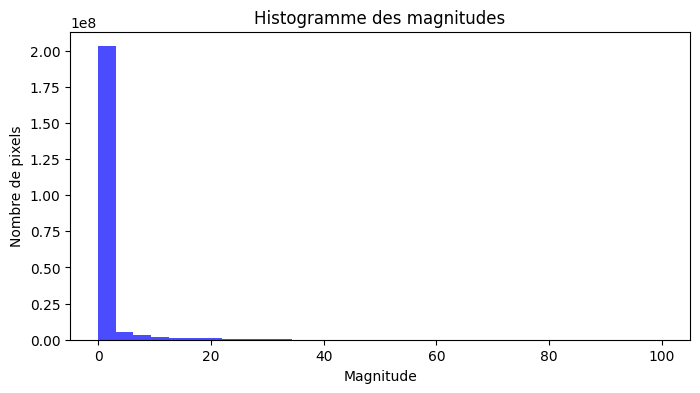

In [17]:
def plot_magnitude_histogram(magnitudes, bins=32):
    plt.figure(figsize=(8,4))
    plt.hist(magnitudes, bins=bins, color='blue', alpha=0.7)
    plt.title("Histogramme des magnitudes")
    plt.xlabel("Magnitude")
    plt.ylabel("Nombre de pixels")
    plt.show()

plot_magnitude_histogram(magnitudes, bins=32)


**Q11/** Ecrivez une fonction qui filtre un flux optique en mettant à zéro les points dont la magnitude est inférieure au seuil minimal et supérieure au seuil maximal identifiés en **10**.

In [18]:
def filter_flow_by_magnitude(flow_mo, min_mag, max_mag):
    """
    Met à zéro les flux dont la magnitude est < min_mag ou > max_mag
    """
    H = flow_mo[...,0]
    M = flow_mo[...,1]
    mask = (M >= min_mag) & (M <= max_mag)
    M_filtered = M * mask
    return np.stack([H, M_filtered], axis=2)


**Q12/** Ecrivez une fonction qui calcule un histogramme de flux optique en partant de la représentation `(orientation, magnitude)` en ignorant les points ayant une `magnitude==0`.

Pour cela vous devrez fragmenter l’espace `(orientation, magnitude)`. Si vous souhaitez disposer de `o_bins` pour fragmenter l’orientation et de `m_bins` pour fragmenter la magnitude, vous allez construire un vecteur disposant de `o_bins*m_bins` cases.

L’étendue d’une cellule sera de `o_bin_etendue = 360/o_bins` degrés pour les orientations et de `m_bin_etendue = max_mag/m_bins` pour les magnitudes.
Vous pourrez ensuite adapter la fonction color_histogram (fournie en *TP2*) pour remplir l’histogramme. 

Vous pouvez aussi choisir une implémentation moins efficace en parcourant les points composants le flux optiques et en incrémentant la case correspondante `bin_o*m_bins+bin_m`, où :
* `bin_o` correspond au bin d’orientation où le point `(o,m)` devra se trouver (`=o/o_bin_etendue`) et 
* `bin_m` correspond au bin de magnitude où le point `(o,m)` devra se trouver (`=m/m_bin_etendue`).  

In [19]:
def histogram_orientation_magnitude(flow_mo, o_bins=32, m_bins=32, max_mag=None):
    """
    Crée un histogramme 2D orientation+magnitude
    flow_mo : (H, W, 2)
    """
    H = flow_mo[...,0]
    M = flow_mo[...,1]
    if max_mag is None:
        max_mag = np.max(M)
    o_bin_size = 360 / o_bins
    m_bin_size = max_mag / m_bins

    hist = np.zeros(o_bins * m_bins, dtype=np.float32)
    for i in range(H.shape[0]):
        for j in range(H.shape[1]):
            if M[i,j] == 0:
                continue
            bin_o = min(int(H[i,j] // o_bin_size), o_bins-1)
            bin_m = min(int(M[i,j] // m_bin_size), m_bins-1)
            hist[bin_o * m_bins + bin_m] += 1
    hist /= np.sum(hist)
    return hist


**Q13/** Calculez un histogramme moyen pour une vidéo en partant des histogramme de flux optique calculés entre deux images successives et filtré comme indiqué en **Q11**.

In [20]:
def mean_histogram_video_flow(video_frames, min_mag=1, max_mag=20, o_bins=32, m_bins=32):
    """
    Calcule l'histogramme moyen de flux optique pour une vidéo entière
    """
    gray_frames = [cv2.cvtColor(f, cv2.COLOR_RGB2GRAY) for f in video_frames]
    hists = []
    max_mag_all = 0
    flows_mo = []

    for i in range(len(gray_frames)-1):
        flow = optical_flow_farneback(gray_frames[i], gray_frames[i+1])
        flow_mo = flow_to_orientation_magnitude(flow)
        flow_mo = filter_flow_by_magnitude(flow_mo, min_mag, max_mag)
        flows_mo.append(flow_mo)
        max_mag_all = max(max_mag_all, np.max(flow_mo[...,1]))

    # Calcul histogrammes
    for flow_mo in flows_mo:
        hist = histogram_orientation_magnitude(flow_mo, o_bins, m_bins, max_mag=max_mag_all)
        hists.append(hist)
    
    return np.mean(hists, axis=0)


**Q14/** Réappliquer les protocoles de classification de la **Q3 et Q5** sur ces nouveaux histogrammes moyens. Reporter et discuter les résultats.

In [ ]:
# Exemple : protocole Q3/Q5
mean_acc_flow, std_acc_flow = classify_videos(
    all_videos, labels, 
    lambda v: mean_histogram_video_flow(v, min_mag=1, max_mag=20),
    n_splits=4
)
print(f"Accuracy cross-val 4 folds (histogramme flux orientation+magnitude): {mean_acc_flow:.4f} ± {std_acc_flow:.4f}")


/tmp/ipykernel_28190/3824816166.py:21: RuntimeWarning: invalid value encountered in divide
  hist /= np.sum(hist)


**Q15/** Réappliquer le protocole de classification de la **Q3 et Q5** en considérant cette fois-ci uniquement des histogrammes d'orientation (en ignorant les magnitudes des flux) et en laissant également de côté les flux ayant une `magnitude == 0`. Reporter et discuter les résultats.

In [ ]:
def histogram_orientation_only(flow_mo, o_bins=32):
    """
    Histogramme basé uniquement sur orientation (ignorer magnitudes=0)
    """
    H = flow_mo[...,0]
    M = flow_mo[...,1]
    hist = np.zeros(o_bins, dtype=np.float32)
    o_bin_size = 360 / o_bins

    for i in range(H.shape[0]):
        for j in range(H.shape[1]):
            if M[i,j] == 0:
                continue
            bin_o = min(int(H[i,j] // o_bin_size), o_bins-1)
            hist[bin_o] += 1
    hist /= np.sum(hist)
    return hist

def mean_histogram_video_orientation(video_frames, min_mag=1, max_mag=20, o_bins=32):
    gray_frames = [cv2.cvtColor(f, cv2.COLOR_RGB2GRAY) for f in video_frames]
    hists = []
    for i in range(len(gray_frames)-1):
        flow = optical_flow_farneback(gray_frames[i], gray_frames[i+1])
        flow_mo = flow_to_orientation_magnitude(flow)
        flow_mo = filter_flow_by_magnitude(flow_mo, min_mag, max_mag)
        hist = histogram_orientation_only(flow_mo, o_bins=o_bins)
        hists.append(hist)
    return np.mean(hists, axis=0)

# Classification uniquement orientation
mean_acc_orientation, std_acc_orientation = classify_videos(
    all_videos, labels,
    lambda v: mean_histogram_video_orientation(v, min_mag=1, max_mag=20),
    n_splits=4
)
print(f"Accuracy cross-val 4 folds (orientation uniquement): {mean_acc_orientation:.4f} ± {std_acc_orientation:.4f}")


**Q16/** Faites varier les seuils de filtrage obtenus en **Q10** et refaites les experimentations de la **Q14** (au minium 2 autres valeurs pour le seuil haut et 2 autres valeurs pour le seuil bas). Reporter et discuter les résultats.

In [ ]:
# Seuils min et max de magnitude à tester
min_mags = [1, 2, 3]    # 2 autres valeurs pour le seuil bas
max_mags = [15, 20, 25] # 2 autres valeurs pour le seuil haut

results = []


In [ ]:
for min_mag in min_mags:
    for max_mag in max_mags:
        print(f"\n--- Test min_mag={min_mag}, max_mag={max_mag} ---")
        
        mean_acc, std_acc = classify_videos(
            all_videos, labels,
            lambda v: mean_histogram_video_flow(v, min_mag=min_mag, max_mag=max_mag, o_bins=32, m_bins=32),
            n_splits=4,
            display_report=False  # on ne veut pas tous les rapports
        )
        results.append({
            'min_mag': min_mag,
            'max_mag': max_mag,
            'mean_acc': mean_acc,
            'std_acc': std_acc
        })


In [ ]:
import pandas as pd

df_results = pd.DataFrame(results)
print(df_results.sort_values(by='mean_acc', ascending=False))


In [ ]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.heatmap(df_results.pivot("min_mag", "max_mag", "mean_acc"), annot=True, fmt=".3f", cmap="Blues")
plt.title("Impact des seuils min/max sur l'accuracy (flux orientation+magnitude)")
plt.xlabel("max_mag")
plt.ylabel("min_mag")
plt.show()


## Vidéos - flux optiques comme images RGB (optionnel)

**Q17/** A partir des images `RGB` illustrant les flux (voir **Q7**), vous pouvez réappliquer la même méthodologie décrite en **Q1**-**Q2** afin de calculer un descripteur global de la vidéo.

**Q18/** Ecrire une fonction qui calcule un histogramme moyen pour une vidéo, à partir des histogrammes couleur de chaque image `RGB` illustrant le flux optique entre deux images successives.

**Q19/** Si l'on considère l'histogramme moyen des images RGB des flux comme un descripteur pour une vidéo, mettez en place les protocoles de classification décrites dans les **Q3 et Q5**.

Reporter et discuter les résultats.